### Recommended literature for FRESEAN mode analysis

M. A. Sauer & M. Heyden, *J. Chem. Theory Comput.* **2023**, 19, 5481-5490.

### Import modules

The custom modules <font style="font-family: courier; color: red">unwrap</font> and <font style="font-family: courier; color: red">align</font> include compiled functions written in `C` made available by the <font style="font-family: courier; color: red">ctypes</font> package. 

Make sure to compile the `C` code in the <font style="font-family: courier; color: cyan">ctypes/</font> directory.

With a UNIX-based OS (Linux or MacOS) with GCC installed, this should work by executing the provided script: <font style="font-family: courier; color: cyan">ctypes/compile.sh</font>

The custom module <font style="font-family: courier; color: red">graphics</font> provides visualization classes to plot spectra and to generate 3D images of molecules with optional addition of arrows to indicate vibrational modes.

<details>
    <summary><strong>Do you need the custom modules?</strong></summary>

>   **Module <font style="font-family: courier; color: red">unwrap</font>**   
>   This module makes sure that all molecules in your system are 'whole', i.e., no bonds are longer than half the box size. 
>   If you already made sure that this is the case (true for all trajectories provided for this tutorial), especially for the molecule(s) you are analyzing, you can remove this module and any instances of the `unwrap` class. 
>   If your system is not periodic, the `single_frame()` function will print a warning message, but will do no harm.
>
>   **Module <font style="font-family: courier; color: red">align</font>**   
>   This module provides routines for translational and rotational fitting of a selection of your system to reference coordinates. 
>   You will need this module for the trajectories provided for this tutorial.It applies rotations not just to coordinates but also velocities. This is essential for FRESEAN mode analysis and is typically not done by other alignment tools. 
>   Only if you can confirm that your molecule does not rotate at all during your simulation, e.g., it is embedded in the crystal of a solid, you may be able to remove this module and any instances of the `align` class.
>   If no periodic box information is present in your trajectory (i.e., for a single molecule in the gas phase), the `align` module will print a warning message and use a dummy box.
>
>   **Module <font style="font-family: courier; color: red">graphics</font>**
>   This module is entirely optional. Feel free to visualize differently, use your own modules etc. Just remove the instances of any classes imported from the <font style="font-family: courier; color: red">graphics</font> module (imported as `g`).

</details>

In [1]:
import os
import urllib.request
# numpy makes python fast
import numpy as np
# MDAnalysis provides an interface to many topology and trajectory formats
import MDAnalysis as mda
from MDAnalysis.analysis.dihedrals import Dihedral
# tqdm gives us progress bars
from tqdm import *
# Fourier transforms from scipy
from scipy.fft import fft, ifft
# matplotlib for plotting
import matplotlib.pyplot as plt
# custom modules (included)
import unwrap as pbc
import align as fit
import graphics as g # custom module for 2D and 3D graphics

### System setup

<details>
    <summary>Description of user input</summary>

>   - if needed, download input files
>   - create MDAnalysis Universe
>   - create atom selection
>   - set number of constraints applied to selection
>   - provide reference coordinates
>   - define number of time steps in correlation functions
>   - define time step between frames saved in trajectory
>   - determine width of Gaussian window for spectra convolution

</details>

In [2]:
def download_if_needed(filename, url):
    if not os.path.exists(filename):
        print(f"{filename} not found. Downloading from {url} ...")
        urllib.request.urlretrieve(url, filename)
        print(f"Downloaded {filename}.")

# We start with a simulation trajecotry of alanine dipeptide in the gas phase at 50K. 
# In this case, we expect a molecule to behave as harmonic as possible, 
# which allows us to make a fair one-to-one comparison between harmonic and FRESEAN mode analysis.
# We will then observe how anharmonic effects become more dominant: 
# 2) in the gas at room temperature (02-tutorial_MD-gas-300K.ipynb) 
# 3) and then in solution (03-tutorial_MD-water-300K.ipynb).
download_if_needed("data/MD-gas-50K/topol.tpr", "https://www.dropbox.com/scl/fi/dz5q0x8cxm268t5hveua3/topol.tpr?rlkey=3bjvvem9xvmraa2xj9lihbbqk&dl=1")
download_if_needed("data/MD-gas-50K/traj.trr", "https://www.dropbox.com/scl/fi/0gwbhaocef8fs0sizagab/traj.trr?rlkey=di38cgr9ozsvi8c8vtsy3kp69&dl=1")
u = mda.Universe("data/MD-gas-50K/topol.tpr","data/MD-gas-50K/traj.trr")

# select the atoms used for analysis (trajectories provided here contain only atoms from alanine dipeptide)
sel = u.select_atoms("all")
# center of mass translation and rotation is removed during the MD to avoid the flying ice-cube effect
nConstraints = 6 # constraints applied to atoms in selection
# if you have specific reference coordinates for the alignment, define them here
# otherwise leave 'altRefPos' as None when creating the instance of fit.align()
# -> in that case, the first time frame of the trajecotry will be used
uRef = mda.Universe("data/harmonic-normal-modes/min.xyz")
align = fit.align(u, sel, rotVel=1, placeCOMInBox=0, altRefPos=uRef.atoms.positions)
# define correlation time, time step in trajectory, and Gaussian window size
nCorr = 500 # in time frames
dt = 0.004 # in ps
sigma = 10.0 # in cm**-1

align: WARNING:
 -> no box dimensions in trajectory
 -> using cubic (100 A)**3 box as dummy


/usr/local/anaconda3/envs/mda/lib/python3.12/site-packages/MDAnalysis/coordinates/XDR.py:240: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


### Setup analysis

In [3]:
unwrap = pbc.unwrap(u) # make all molecules whole

# len of trajectory: needed to allocate arrays
nFrames = len(u.trajectory)
# number of atoms in selection
nAtoms = sel.n_atoms
# number of degrees of freedom (DOF) in selection
nDOF = nAtoms * 3 - nConstraints
# allocate arrays to store atomic velocities
velocities = np.zeros((nAtoms * 3, nFrames), dtype=np.complex128)
# store square root of atomic masses for each DOF
sqm = np.repeat(np.sqrt(sel.atoms.masses), 3)

# define Gaussian window for FFT
# - frequency resolution in cm**-1
wn0 = 1.0 / ((2 * nCorr -1) * dt) * 33.3564
# - frequency range for spectra
freqs = np.arange(nCorr) * wn0
# normalization factor for Gaussian window function in frequency domain
winNorm = 1.0 / np.sqrt(2.0 * np.pi * sigma**2)
# - array to store Gaussian window (in time and frequency domain)
winFreq = np.zeros(2 * nCorr - 1)
winTime = np.zeros(2 * nCorr - 1)
# create Gaussian window in frequency domain
# - first half is Gaussian, second half is a mirror image
# - this is to ensure that the window is real-valued in the time domain
winFreq[0:nCorr] = winNorm * np.exp(-0.5 * freqs**2 / sigma**2)
winFreq[nCorr:] = winFreq[nCorr-1:0:-1]
# generate the Gaussian window in time domain
winTime = np.real(ifft(winFreq))

# allocate the velocity correlation matrix
corrMatrix = np.empty((nCorr, nAtoms * 3, nAtoms * 3))

### Loop over trajectory

- unwrap periodic boundary conditions if needed
- perform translational/rotational alignment (rotate velocities)
- store $\sqrt{m} \cdot \tilde{\mathrm{v}}(t)$ for all atoms in selection

In [4]:
for i, ts in enumerate(tqdm(u.trajectory)):
    unwrap.single_frame()
    align.single_frame()
    velocities[:, i] = sqm * sel.velocities.flatten()

  0%|          | 534/250001 [00:00<00:46, 5338.60it/s]

unwrap: WARNING:
 -> no box dimensions available!
 -> skipping unwrap!


100%|██████████| 250001/250001 [00:43<00:00, 5700.20it/s]


## **FREquency-SElective ANharmonic (FRESEAN) mode analysis: Part 1**

### **Computing the velocity correlation matrix $\mathbf{C}_{\tilde{\mathrm{v}}}$**

<details>
    <summary>Open for equation 1</summary>

We need to compute the elements of the mass-weighted velocity correlation matrix $\mathbf{C}_{\tilde{\mathrm{v}}}$, either in the time or frequency domain. 
The matrix elements in the time and frequency domains are given as:

$$
C_{\tilde{\mathrm{v}},ij}(\tau) = \langle \tilde{\mathrm{v}}(t) \cdot \tilde{\mathrm{v}}(t+\tau)\rangle_t \\
C_{\tilde{\mathrm{v}},ij}(\omega) = \int_{-\infty}^{+\infty} \mathrm{exp}\left(\mathrm{i} \omega \tau \right) \, C_{\tilde{\mathrm{v}},ij}(\tau) \, d\tau
\tag{1}
$$

Here, the indices $i$ and $j$ stand for individual DOF.  The brackets $\langle \ldots \rangle_t$ mean that we are averaging over all time frames in the trajectory or: 

$$
\langle \ldots \rangle_t = \frac{1}{t_{\mathrm{max}}-t_{\mathrm{min}}} \int_{t_{\mathrm{min}}}^{t_{\mathrm{max}}} \ldots(t) dt
$$

</details>

#### **Fast computation of correlation functions via FFT**
<details>
    <summary>Open for equations 2 and 3</summary>

Calculating correlation functions (here: very many of them) as simple products in the **time** domain is inefficient. Instead, using a variant of the ***convolution theorem***, we can compute these correlation functions much more efficiently in the **frequency** domain.

First, we compute the Fourier transform of all ($\sqrt{m}$-weighted) velocities (for each DOF):

$$
\tilde{\mathrm{v}}_i(\omega) = \int_{-\infty}^{+\infty} \mathrm{exp}\left(\mathrm{i} \omega t \right) \,  \tilde{\mathrm{v}}(t) \, dt
\tag{2}
$$

The results will be complex-valued and we need to prepare the corresponding arrays accordingly. Now, we can compute compute the Fourier transform of the time correlation functions simply as a product:

$$
C_{\tilde{\mathrm{v}},ij}(\omega) = \tilde{\mathrm{v}}_i(\omega) \cdot \overline{\tilde{\mathrm{v}}_j(\omega)}
\tag{3}
$$

Here, $\overline{\tilde{\mathrm{v}}_j(\omega)}$ indicates the complex conjugate. The result is equivalent to a Fourier transform of the corresponding correlation function from the time domain into the frequency domain as defined in Eq. 1.

However, in almost all practical cases the fast Fourier transform algorithm requires **a lot fewer** floating point operations compared to the direct computation of the time correltion function in the time domain.

</details>

#### **Enforcing time symmetry**

<details>
    <summary>Open for equation 4</summary>

For all auto-correlations ($i=j$), the resulting $C_{\tilde{\mathrm{v}},ii}(\omega)$ is real-valued and symmetric in the frequency-domain ($C_{\tilde{\mathrm{v}},ii}(\omega)=C_{\tilde{\mathrm{v}},ii}(-\omega)$). This the case because for any complex number $z = x + \mathrm{i} y$, we get $z \cdot \overline{z} = x^2 + y^2$.

This is not necessarily the case for the cross-correlations ($i\neq j$).
If computed from simulation trajectories of finite length, $C_{\tilde{\mathrm{v}},ij}(\omega)$ will be complex-valued with symmetric real-part and an anti-symmetric imaginary component. 

$$
\mathrm{Re}\left[C_{\tilde{\mathrm{v}},ij}(\omega)\right] = \mathrm{Re}\left[C_{\tilde{\mathrm{v}},ij}(-\omega)\right] \\
\mathrm{Im}\left[C_{\tilde{\mathrm{v}},ij}(\omega)\right] = -\mathrm{Im}\left[C_{\tilde{\mathrm{v}},ij}(-\omega)\right]
$$

However, for a system in equilibrium, there is no specific direction in time (the system is not evolving). Therefore, we require that all time cross-correlation functions must be symmetric in time, i.e., $C_{\tilde{\mathrm{v}},ij}(\tau) = C_{\tilde{\mathrm{v}},ij}(-\tau)$. As a direct consequence, the Fourier transform of time cross-correlation functions computed from equilibrium trajectories must be real-valued. In other words, we can ignore the imaginary components (which should be small anyways):

$$
C_{\tilde{\mathrm{v}},ij}(\omega) \overset{!}{=} \mathrm{Re}\left[C_{\tilde{\mathrm{v}},ij}(\omega)\right]
\tag{4}
$$

</details>

#### **Adjusting frequency resolution and reducing noise**

<details>
    <summary>Open for equations 5 and 6</summary>

Because the integrals in Eq. 2 are over the entire simulation time, our correlation functions in the frequency domain computed in Eq. 3 will have a very fine-grained frequency resolution.

$$
\omega_0 = \frac{2 \pi}{t_{\mathrm{max}}-t_{\mathrm{min}}}
$$

This might sound good: we can resolve very small differences between frequencies. However, this comes at the price of a very low signal-to-noise ratio. In other words, we need to reduce the amount of noise in our spectrum by reducing the frequency resolution. 

The simplest way to reduce the frequency resolution would be to average intensities at nearby frequencies. However, window functions provide a more elegant solution. First, we transform our correlation functions into the time domain:

$$
C_{\tilde{\mathrm{v}},ij}(\tau) = \frac{1}{2 \pi} \int_{-\infty}^{+\infty} \mathrm{exp}\left(-\mathrm{i} \omega \tau \right) \, C_{\tilde{\mathrm{v}},ij}(\omega) \, d\omega
\tag{5}
$$

Whether, we perform a true inverse Fourier transform or not ($-\mathrm{i}$ instead of $+\mathrm{i}$ in argument of exponential), does not really matter, apart from the $1/2\pi$ pre-factor caused by the implied substitution: $d\omega = 2 \pi d\nu$.
Because we enforced that all $C_{\tilde{\mathrm{v}},ij}(\omega)$ are symmetric and real-valued, we could also perform cosine transforms from here on. 

Note:
- different conventions for Fourier transform pre-factors exist
- for numerical FFTs the prefactors are proportional to the number of data points in the transformed array, not $2\pi$

Now, that we have our correlation functions in the time domain, we can reduce the maximum correlation time which in turn reduces the frequency resolution (increases $\omega_0$). We simply ignore any data past our chosen $\tau_{\mathrm{max}}$, before we transform back into the frequency domain.

$$
C_{\tilde{\mathrm{v}},ij}(\omega) = \int_{-\tau_{\mathrm{max}}}^{+\tau_{\mathrm{max}}} \mathrm{exp}\left(\mathrm{i} \omega \tau \right) \, C_{\tilde{\mathrm{v}},ij}(\tau) \, d\tau
\tag{6}
$$

If the roles of time and frequency would be inverted, this would be the equivalent of a low-pass frequency filter. Here it is a low-pass time filter.
Notably, our data is still averaged over the entire simulation trajectory. We are only limiting the maximum time difference between time frames that are considered for the time correlation function defined in Eq. 1. 

Now the frequency resolution can be freely adjusted based on our choice of $\tau_{\mathrm{max}}$:

$$
\omega_0 = \frac{2 \pi}{2 \tau_{\mathrm{max}}}
$$

What we do not alter is the highest frequency in our spectrum, which is determined by the time resolution in our trajectory, i.e., the time between succinct time frames $\Delta t$ (see Nyquist theorem). 
However, we are reducing the number of frequency points in our spectrum. As a positive side effect, we need a lot less memory to store the frequency-dependent correlation matrix. This is particularly relevant for systems with many DOFs that result in large numbers of matrix elements.

</details>

#### **Smooth spectra through convolution with Gaussian window function**

<details>
    <summary>Open for equations 7 and 8</summary>

In addition to reducing the number of sampled frequencies, we may aim to reduce the frequency resolution further, either to increase the signal-to-noise ratio or to ensure that our time correlations smoothly decay to zero within $\tau_{\mathrm{max}}$ (we will see later that this is an issue in the gas phase, where damping is low). 
This can be done via a convolution of the spectrum with a window function. In this case, we will use a Gaussian window.

$$
\mathrm{w}(\omega) = \frac{1}{\sqrt{2 \pi \sigma^2}} \mathrm{exp}\left(-\frac{\omega^2}{2 \sigma^2}\right)
$$

The convolution can be formally written as:

$$
\left[C_{\tilde{\mathrm{v}},ij}(\omega) * w(\omega)\right] = \int_{-\infty}^{+\infty} C_{\tilde{\mathrm{v}},ij}(\omega') \cdot w(\omega-\omega') \, d\omega'
\tag{7}
$$

For any given frequency $\omega$, one can visualize this convolution as the spectrum $C_{\tilde{\mathrm{v}},ij}(\omega')$ multiplied with a Gaussian function centered at $\omega$. All intensities for frequencies close to $\omega$, i.e., close to the peak of the Gaussian, are kept and weighted. All intensities for frequencies far from $\omega$ are effectively multiplied by zero. The integration adds everything up to obtain a weighted average of the intensities near $\omega$. 

We can control the effective frequency resolution through $\sigma$. A large $\sigma$ results in a wide Gaussian. Thus we average over many frequencies and reduce the effective frequency resolution. A small $\sigma$ transforms the Gaussian into the equivalent of a $\delta$-function and does not change the spectrum at all.

The evaluation of Eq. 6 is again computationally costly (similar to the correlation functions). However, again, there is an easier way to obtain the same result using the convolution theorem. In this case, we aim to perform a convolution in the frequency domain. To do this efficiently, we perform this operation in the time domain. 

To get $C_{\tilde{\mathrm{v}},ij}(\tau)$, we do not have to do anything. We simply do not yet perform the Fourier transform in Eq. 6. We only need to transform the Gaussian window function from the frequency into the time domain. We can do this numerically (see code in section "System setup" above) or analytically:

$$
\mathrm{w}(\tau) = \frac{1}{2 \pi} \int_{-\infty}^{+\infty} \mathrm{exp}\left(-\mathrm{i} \omega \tau \right) \, \mathrm{w}(\omega) \, d\omega = \frac{1}{2 \pi} \mathrm{exp}\left(-\frac{\sigma^2 \tau^2}{2}\right)
$$

The Gaussian window function is symmetric and real-valued in both the frequency and time domain. Thus, again the distinction between forward and inverse Fourier transforms is not really important here (apart from the pre-factor).

Now, we can perform the convolution in Eq. 7 entirely as a product in the time domain, followed by a Fourier transform from the time into the frequency domain:

$$
C_{\tilde{\mathrm{v}},ij}(\omega) \approx \left[C_{\tilde{\mathrm{v}},ij}(\omega) * \mathrm{w}(\omega)\right] = \int_{-\infty}^{+\infty} \mathrm{exp}\left(\mathrm{i} \omega \tau \right) \, C_{\tilde{\mathrm{v}},ij}(\tau) \cdot \mathrm{w}(\tau)\, d\tau
\tag{8}
$$

</details>

In [5]:
# Fourier transform of velocities (Eq. 2 above)
velocities = fft(velocities, axis=1)

# arrays for temporary data storage
tmp1 = np.zeros(nFrames, dtype=np.float64)
tmp2 = np.zeros(nFrames, dtype=np.float64)
tmp3 = np.zeros(2 * nCorr -1, dtype=np.float64)
# loop over all correlation matrix elements
for i in tqdm(range(nAtoms * 3)):
    for j in range(i, nAtoms * 3):
        # one element of correlation matrix
        # multiply Fourier transformed velocities (Eq. 3 above)
        # and enforce real-valued result (Eq. 4 above)
        tmp1 = np.real(velocities[i] * velocities[j].conj())
        # transform from frequency into time domain (Eq. 5 above)
        tmp2 = np.real(ifft(tmp1))
        # cut off time domain data after tau_max = nCorr * dt
        tmp3[:nCorr] = tmp2[:nCorr]
        # enforce time symmetry of truncated time correlation function
        tmp3[nCorr:] = tmp2[nCorr-1:0:-1]
        # multiply with Gaussian window function in time domain (Eq. 8 above)
        tmp3 *= winTime
        # and Fourier transform into frequency domain (Eq. 8 above)
        corrMatrix[:,i, j] = np.real(fft(tmp3)[:nCorr])
        if i != j:
            # use symmetry of correlation matrix
            corrMatrix[:, j, i] = corrMatrix[:, i, j]
# correct for implicit multiplication in power spectrum
corrMatrix /= nFrames
# free memory used to store velocities and temporary data
del velocities, tmp1, tmp2, tmp3

100%|██████████| 66/66 [00:21<00:00,  3.01it/s]


## **FRESEAN mode analysis: Part 2**

### **Computing eigenvectors an eigenvalues**

<details>
    <summary>Open for equation 9 and 10</summary>

Now that we computed the velocity correlation matrix $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$, we can diagonalize it for any frequency. In other words, we compute its eigenvalues and eigenvectors.

$$
\mathbf{C}_{\tilde{\mathrm{v}}}(\omega) = \mathbf{Q}(\omega) \begin{pmatrix}\lambda_1(\omega) & \dots & 0 \\ \vdots & \ddots & \vdots \\ 0 & \dots & \lambda_{3N}(\omega)\end{pmatrix} \mathbf{Q}^T(\omega)
\tag{9}
$$

The sum of the eigenvalues $\lambda_i(\omega)$ at any frequency is directly proportional to the vibrational density of states or VDoS:

$$
I_{\mathrm{VDoS}}(\omega) = \frac{2}{k_B T} \sum_{i}^{3N} \lambda_i(\omega)
\tag{10}
$$

We keep track of all unit conversions, implied pre-factors during the Fourier transforms, etc. Then it is straightforward to compute the average temperature of the analyzed system using the relation:

$$
N_{\mathrm{DOF}} = \frac{1}{2\pi} \int_0^{\infty} I_{\mathrm{VDoS}}(\omega) \, d\omega
$$

The analytical and numerical integrals look a bit different, especially because dealing with symmetry is a bit finicky with discrete data. We do this correctly when we compute the average temperature. 
However, for the final representation of the VDoS, we just normalize it so that a simple summation over intensities (at positive frequencies) results in the number of corresponding DOF. 
In actuality, we'd need to symmetrize (include negative frequencies), sum over positive and negative frequencies, without counting the zero frequency intensity twice, and divide by 2.

When we transform back into the time domain, we correct for the resutling small error so that the zero-time delay point of each velocity auto-correlation correctly describes the average kinetic energy and can be converted into a temperature.

</details>


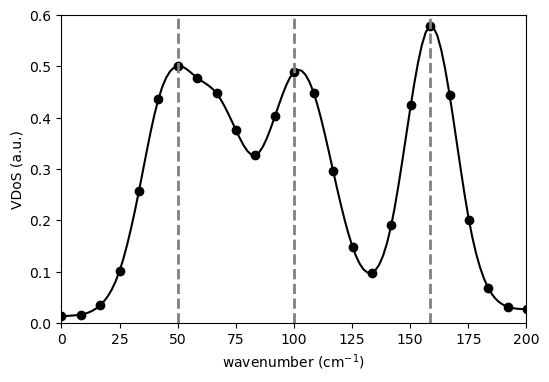

In [6]:
eigenvalues = []
eigenvectors = []
for i in range(nCorr):
    vals, vecs = np.linalg.eigh(corrMatrix[i])
    # sort eigenvalues and eigenvectors in descending order
    idx = np.argsort(vals)[::-1] # indices for descending order
    vals = vals[idx]
    vecs = vecs[:, idx]
    eigenvalues.append(vals)
    # Note: access i'th eigenvector as vecs.T[i]
    eigenvectors.append(vecs.T) # transpose to have eigenvectors as rows
# convert lists to numpy arrays
eigenvalues = np.array(eigenvalues)
eigenvectors = np.array(eigenvectors)

# here we compute the average temperature of the system
# we consider some of the idiosyncracies of symmetrized and discretized data
avgTemp = (np.sum(eigenvalues[0]) + 2 * np.sum(eigenvalues[1:])) / (2 * nCorr - 1) / winTime[0] / (8.3145 * 0.1) / nDOF
# this normalization factor for eigenvalues and the corrMatrix ensures that simple sums over VDoS (ignoring symmetry) roughly the corresponding number of DOF
VDoSnorm = nCorr * winTime[0] * (8.3145 * 0.1 * avgTemp)

# normalize eigenvalues and corrMatrix
eigenvalues /= VDoSnorm
corrMatrix /= VDoSnorm

# total VDoS (Eq. 10 avove)
VDoStot = np.sum(eigenvalues, axis=1)
# find peaks in total VDoS
peakIndices = np.where((VDoStot[1:-1] > VDoStot[:-2]) & (VDoStot[1:-1] > VDoStot[2:]))[0] + 1
# peak frequencies
peakFreqs = freqs[peakIndices]

# total vibrational density of states below 200 wavenumbers
g.plotSpectra(freqs, 
            VDoStot, 
            xlim=[0,200], 
            ylim=[0,0.6], 
            vlines = freqs[peakIndices].tolist(),
            filename='figures/MD-gas-50K_totalVDoS.png')

We analyze here specifically the vibrational density of states at low frequencies ($<200\, \mathrm{cm}^{-1}$). Feel free to change the plot range to investigate other part of the vibrational spectrum. You might also want to play with the number of delay times in the correlation function (`nCorr`) and the width of the Gaussian window function (`sigma`).

The low-temperature gas analyzed here has three peaks in the low-frequency range of the VDoS. We will focus our following analysis on the frequencies corresponding to these peaks.

### **Analyzing contributions to selected peaks in the total VDoS**

FRESEAN mode analysis allows us to identify the "vibrational modes", i.e., the specific molecular viibrations, contributing to the total VDoS at any sampled frequency. In the following, we will analyze the 4 vibrational modes that contribute the most to the total VDoS at the selected peak frequencies.

<details>
    <summary>Open for equation 11</summary>

The eigenvectors of $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$, i.e., the rows of $\mathbf{Q}^T(\omega)$, describe collective vibrations of the analyzed molecule. They coorespond to displacement vectors relative to the reference structure used for the translational/rotational fitting. We visualize these vibrations at the end of this notebook. 

The corresponding eigenvalues describe how much a vibration contributes to the total VDoS at the frequency for which the matrix $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ was diagnolized.

A useful property of $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ is that it allows us to easily compute frequency-dependent VDoS contributions of any collective DOF, as long as it is described by a normalized displacement vector. This can be an eigenvector of $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ computed for a given frequency or any other collective DOF in that format. 

We can obtain such a 1D-VDoS also via a projection of $\sqrt{m}$-weighted velocities from the simulation trajectory (applying the same rotations as during calculation of $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$) as described in Sauer et al. (2023). 

However, given a collective DOF described by the displacement vector $\mathbf{q}$, the same result can be obtained simply as:

$$
I_{\mathrm{VDoS},q}(\omega) = \mathbf{q}^T \mathbf{C}_{\tilde{\mathrm{v}}}(\omega) \mathbf{q}
\tag{11}
$$

Note: If we use two different collective DOF, $\mathbf{q}_{1}$ and $\mathbf{q}_{2}$, we obtain information on their cross correlation.

</details>

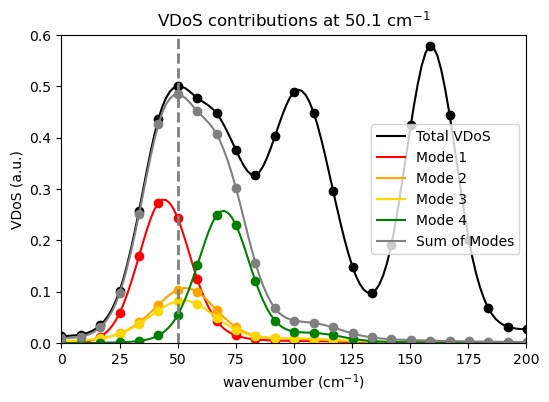

In [7]:
# select low-frequency peaks below 200 wavenumbers
lowFreqPeakIndices = peakIndices[np.where(peakFreqs < 200)[0]]
nLowFreqPeaks = len(lowFreqPeakIndices)
# select number of most important modes to be extracted for each low-frequency peak
nModes = 4
# Selected eigenvectors (vibrational modes) with largest VDoS contribution at each low-frequency peak
lowFreqVibModes = eigenvectors[lowFreqPeakIndices,0:nModes]
# 1D-VDoS for four most contributing vibrational modes at each low-frequency peak
# (see Eq. 11 above)
lowFreqModesVDoS = np.zeros((nLowFreqPeaks, nModes, nCorr))
for p in range(nLowFreqPeaks):
    for m in range(nModes):
        for i in range(nCorr):
            lowFreqModesVDoS[p, m, i] = np.dot(lowFreqVibModes[p, m], np.dot(corrMatrix[i], lowFreqVibModes[p, m]))

# plot 1D-VDoS of vibrational modes contributing most at selected low-frequency peak
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in lowFreqModesVDoS[lowFreqPeakIndex]] + [np.sum(lowFreqModesVDoS[lowFreqPeakIndex], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Sum of Modes'],
            filename='figures/MD-gas-50K_peak-' + f"{lowFreqPeakIndex+1}" + '-modes-VDoS.png',
            vlines = freqs[lowFreqPeakIndices[lowFreqPeakIndex]],
            title = "VDoS contributions at " + f"{freqs[lowFreqPeakIndices[lowFreqPeakIndex]]:.1f}" + " cm$^{-1}$")

Feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the main contributions to the other low-frequency peaks in the VDoS. For each peak, we can see that summing up the 1D-VDoS for the four most contributing vibrations recovers the total VDoS at the peak frequency almost exactly. Consequently, there are no major contributions from other vibrationsa at that frequency.

We can also visualize the eigenvalues directly. The number of non-zero eigenvalues gives us another way to judge how many vibrational modes are contributing to the VDoS at each frequency. Below, we plot the first 10 eigenvalues for each low-frequency peak in the total VDoS.

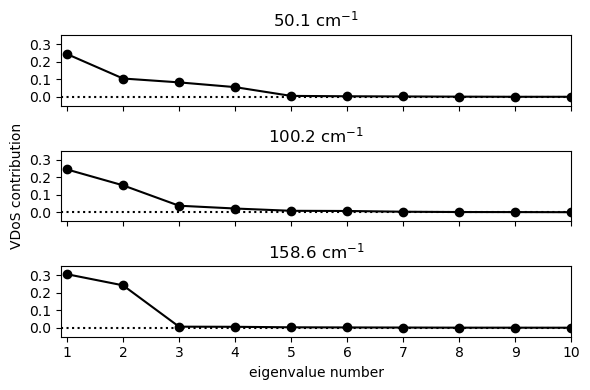

In [8]:
fig, axs = plt.subplots(nLowFreqPeaks, 1, figsize=(6,nLowFreqPeaks * 4/3), sharex=True)

for idx, ax in enumerate(axs):
    ax.plot(range(1, 10 + 1), eigenvalues[lowFreqPeakIndices[idx]][0:10], color='black')
    ax.plot(range(1, 10 + 1), eigenvalues[lowFreqPeakIndices[idx]][0:10], 'o', color='black')
    ax.set_xlim(0.9, 10)
    ax.set_ylim(-0.05, 0.35)
    ax.set_title(f"{freqs[lowFreqPeakIndices[idx]]:.1f} cm$^{{-1}}$")
    hlines = ax.axhline(0, color='black', linestyle=':')
    ax.set_yticks(ticks=np.arange(0.0,0.4,1/10), labels=[f"{x:.1f}" for x in np.arange(0.0,0.4,1/10)])
plt.xticks(ticks=range(1, 10 + 1), labels=range(1, 10 + 1))
axs[-1].set_xlabel("eigenvalue number")
axs[1].set_ylabel("VDoS contribution")
plt.tight_layout()
plt.savefig('figures/MD-gas-50K_lowFreqPeaks-eigenvalues.png', dpi=300)
plt.show()

Our results confirm that no more than four eigenvalues contribute to the VDoS at any of the peak frequencies (for the third peak, just two eigenvalues are non-zero).

We can use Eq. 11 to compute correlation functions between any two distinct degrees of freedom in the frequency domain. We then symmetrize and perform an inverse Fourier transform to get the corresponding time auto and cross corerlation functions. We keep track of units and pre-factors so that we can express the auto-correlations at correlation time tau = 0 in terms of temperature.

Below we generate a 5x5 matrix of correlation functions for the first five vibrational modes (eigenvectors with largest eigenvalues) at a selected peak frequency. 

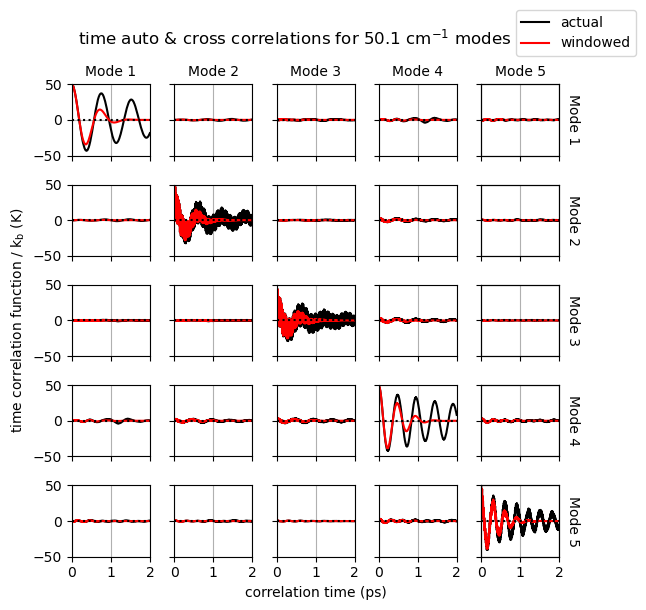

In [9]:
# select low frequency peak for time correlation analysis
# Note: we are not limited to analyzing correlations between vibrational modes at the same frequency
lowFreqPeakIndex = 0 # = 0,1,2 : choose between the peaks in the low-frequency VDoS
idx = lowFreqPeakIndices[lowFreqPeakIndex]
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(5, 5, figsize=(6,6), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectors[idx, i], np.dot(corrMatrix[k], eigenvectors[idx, j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # convert to mode temperature
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * nCorr
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-50, 50)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][2].set_xlabel("correlation time (ps)")
axs[2][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for {freqs[idx]:.1f} cm$^{{-1}}$ modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-50, 51, 50))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,4]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.08, 1.02))
plt.savefig('figures/MD-gas-50K_peak-' + f"{lowFreqPeakIndex+1}" + '-5x5-time-correlations.png', dpi=300)
plt.show()

Feel free to change the `lowFreqPeakIndex` above (choose 0, 1 or 2) to analyze the correlations between vibrational modes contributing to the VDoS at the other low-frequency peaks.

Note the small cross correlations between distinct vibrational modes identified here. In part, this is expected because the vibrational modes obtained at the same frequency are eigenvectors of the same matrix and thus orthogonal to each other. On the other hand, these vibrations were selected for their contributions to the VDoS at the same frequency (as long as the corresponding eigenvalue is larger than zero). 

This provides a first contrast to harmonic normal modes, where vibrations at the same frequency woul be degenerate and cannot be separate from each other.

Note:
We can also observe the effect of the window function. Without the window function, the oscillations in the correlation functions for this gas-phase system continue past the maximum correlation time. To avoid potential artificats in the Fourier transform, which implies that the symmetrized time correlation function is periodic, we would need to increase `nCorr`. However, the window function let's the correlation functions decay to zero smoothly within our maximum correlation time of 2 picoseconds.


### **Finding key anharmonic vibrations**

<details>
    <summary>Open for equation 12</summary>

FRESEAN mode analysis provides us with a full complement of orthogonal vibrational modes for every sampled frequency. This is perfect if we want to know which vibrations contribute to the VDoS at a given frequency. 

However, if we want a more general description of all vibrations in the molecule in a given frequency range, the information can be a overwhelming. Thus, we nee to find a method to mine that information. 

The following is not meant to provide a general recipe, which will depend on the specific questions you want to answer. Instead, this is mean to provide an initial idea on how to work with the result.

To simplify things, we recall that the vast majority of eigenvalues are zero or near-zero and the corresponding eigenvectors can be ignored. In addition, the character of vibrational modes with large contributions to the VDoS varies smoothly with frequency. Thus the total number of vibrations in a given frequency range is limited.

To isolate key vibrations of a molecule that dominate its spectrum in a particular range of frequencies, we first compute a pair-wise similarity matrix between vibrational modes (dot product of normalized vectors) at distinct frequencies and weight the results by the corresponding eigenvalues:

$$
M_{\mathrm{cluster},ij} = \frac{\lambda_i \cdot \lambda_j}{\mathrm{max}(\lambda)} \cdot \mathbf{Q}_i^T \mathbf{Q}_j
\tag{12}
$$

To simplify this, we focus on the 5 most important vibrations at all frequences below $200\, \mathrm{cm}^{-1}$.

We note: An alternative approach to achieve this is given by "Generalized Normal Modes" (G. Mathias & M. Baer, J. Chem. Theory Comput. 2011, 7, 2028-2039.), which attempts to diagonlize $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ at all frequencies (in principle one could also select a frequency range) using a single unitary transformation. This transformation is chosen to minimize all off-diagonal elements of $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$. 
A single transformation yields exactly one set of 3$N$ normal modes. While this is convenient for many aplications, it implies strong approximations that are in practice only met by a harmonic system.

</details>

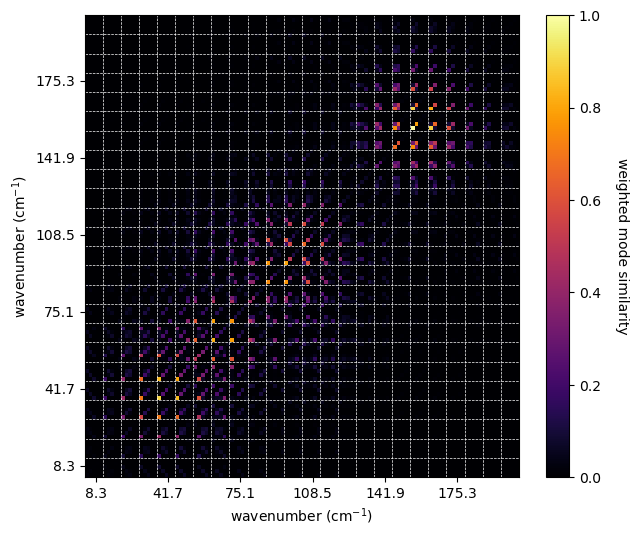

In [10]:
# select eigenvectors and eigenvalues for frequencies below 200 cm$^{-1}$
freqSelIndices = np.where((freqs > 0) & (freqs < 201))[0]
eigenvectorsSel = []
eigenvaluesSel = []
for i in freqSelIndices:
    for m in range(5):
        eigenvaluesSel.append(eigenvalues[i, m])
        eigenvectorsSel.append(eigenvectors[i, m])
eigenvectorsSel = np.array(eigenvectorsSel)
eigenvaluesSel = np.array(eigenvaluesSel)
maxEigenvalue = np.max(eigenvaluesSel)
nSel = len(eigenvaluesSel)

# construct a weighted comparison matrix (see Eq. 12 above)
clusterMatrix = np.zeros((nSel, nSel), dtype=np.float64)
for i in range(nSel):
    if eigenvaluesSel[i] > 0:
        a = np.sqrt(eigenvaluesSel[i])
    else:
        a = 0.0
    for j in range(nSel):
        if eigenvaluesSel[j] > 0:
            b = np.sqrt(eigenvaluesSel[j])
        else:
            b = 0.0
        clusterMatrix[i, j] = a*b/maxEigenvalue*np.abs(np.dot(eigenvectorsSel[i], eigenvectorsSel[j]))

# plot the weighted comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(clusterMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
cbar = plt.colorbar(im)
cbar.set_label('weighted mode similarity', rotation=270, labelpad=20)
plt.xlabel('wavenumber (cm$^{-1}$)')
plt.ylabel('wavenumber (cm$^{-1}$)')
for l in range(5,125,5):
    plt.axhline(l-0.5, color='white', linestyle='--', linewidth=0.5)
    plt.axvline(l-0.5, color='white', linestyle='--', linewidth=0.5)
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.yticks(ticks=np.arange(2.5,117.6,20), labels=np.round(freqs[1:24:4],1))
plt.savefig('figures/MD-gas-50K_clustering-matrix.png', dpi=300)
plt.show()

This clustering matrix contains information on how many unique vibrational modes we detected in the low-frequency spectrum of alanine dipeptide.

#### Clustering of low-frequency vibrations

<details>

We then apply a simple clustering algorithm to identify the low-frequency vibrations that are most representative of all selected vibrations. While we do not set expectations for the number of vibrations that we aim to identify, we introduce a similarity cutoff as a hyper-parameter.

We then compute the 1D-VDoS contributions of the selected modes (computed with Eq. 11) and plot them together with their sum and the total VDoS.

</details>

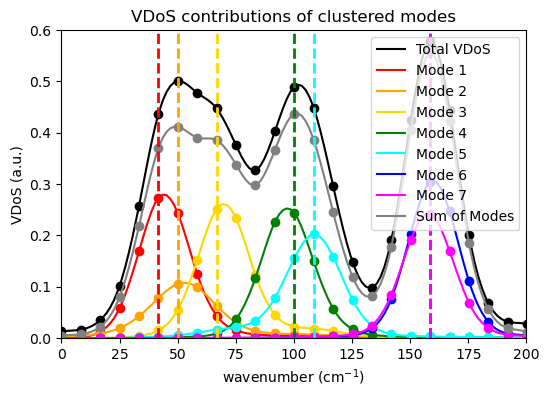

In [11]:
cutoff = 0.3
clusterIndices = []
matrix = clusterMatrix.copy()
if np.max(matrix) > cutoff:
    while True:
        # counts the number of elements in each row that are larger than the cutoff
        row_counts = np.sum(matrix > cutoff, axis=1)
        max_count = np.max(row_counts)
        # if no row has elements larger than the cutoff, break the loop
        if max_count == 0:
            break
        # find the row with the larger number of elements larger than the cutoff
        # this index corresponds to the center of a cluster of similar modes
        # (Note: I avoid the use of np.argmax() here to emulate the exact behavior of a previous implementation of this algorithm in Mathematica)
        max_row_index = np.where(row_counts == max_count)[0][-1]
        # add index to the list of clusters
        clusterIndices.append(max_row_index)
        # find indices of all the elements in the selected row that are larger than the cutoff
        # these are the cluster members and need to be removed from the matrix
        indices_to_remove = np.where(matrix[max_row_index] > cutoff)[0]
        # for all members of current cluster, remove rows and columns from the matrix (set entries to 0)
        matrix[:, indices_to_remove] = 0
        matrix[indices_to_remove, :] = 0
# select the eigenvectors and eigenvalues for the cluster centers
clusterIndices = np.array(clusterIndices)
nClusterModes = len(clusterIndices)
eigenvectorsCluster = eigenvectorsSel[clusterIndices]
eigenvaluesCluster = eigenvaluesSel[clusterIndices]

# compute the 1D-VDoS for the clustered vibrational modes (Eq. 11 above)
VDoSclusterModes = np.zeros((nClusterModes, 25))
for m in range(nClusterModes):
    for i in range(25):
        VDoSclusterModes[m, i] = np.dot(eigenvectorsCluster[m], np.dot(corrMatrix[i], eigenvectorsCluster[m]))

# find the peaks in the 1D-VDoS of clustered vibrational modes
# sort the clustered eigenvectors, eigenvalues, and their 1D-VDoS according to their peak frequency
peak_indices_cluster_modes = np.argmax(VDoSclusterModes, axis=1)
sort_indices = np.argsort(peak_indices_cluster_modes)
peak_indices_cluster_modes = peak_indices_cluster_modes[sort_indices]
clusterIndices = clusterIndices[sort_indices]
eigenvectorsCluster = eigenvectorsCluster[sort_indices]
eigenvaluesCluster = eigenvaluesCluster[sort_indices]
VDoSclusterModes = VDoSclusterModes[sort_indices]

# plot 1D-VDoS of clustered vibrational modes
# to keep things consistent, we plot the 1D-VDoS for the first 7 clustered modes (largest clusters)
g.plotSpectra(freqs[0:25],
            [VDoStot[0:25]] + [arr for arr in VDoSclusterModes[0:7]] + [np.sum(VDoSclusterModes[0:7], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 1', 'Mode 2', 'Mode 3', 'Mode 4', 'Mode 5', 'Mode 6', 'Mode 7', 'Sum of Modes'],
            filename='figures/MD-gas-50K_anharmonic-modes-VDoS.png',
            vlines = freqs[peak_indices_cluster_modes[0:7]].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta'],
            title = "VDoS contributions of clustered modes")

The clustering (using a similarity cutoff of 0.3) identified 7 important vibrations in the low-frequency spectrum of alanine dipeptide. Each vibration has a unimodal spectrum (one peak).

#### Comparing anharmonic vibrational modes

<details>

The clustered anharmonic vibrational modes are not guaranteed (and unlikely) to be exactly orthogonal to each other since they were obtained as eigenvectors of $\mathbf{C}_{\tilde{v}}(\omega)$ at different frequencies. Here, we compute the matrix of dot products betweem, which shows us how much (or how little) the clusterd anharmonic vibrational modes have in common.

</details>

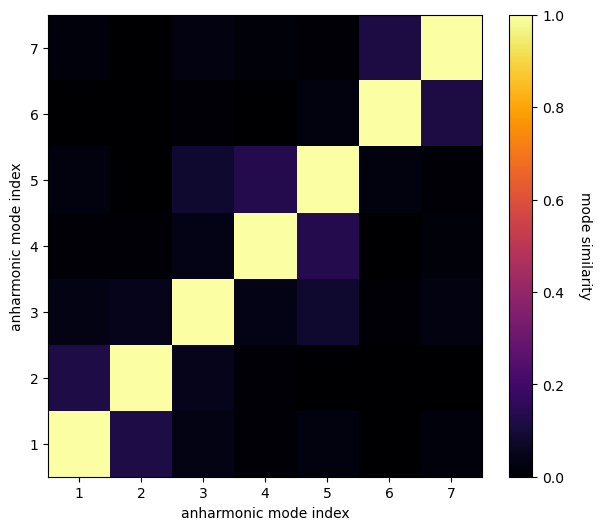

In [12]:
# compute comparison matrix between clustered vibrational modes
compareMatrix = np.zeros((nClusterModes,nClusterModes), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(nClusterModes):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],eigenvectorsCluster[j]))

# plot the comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('anharmonic mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.yticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.savefig('figures/MD-gas-50K_anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

Only eigenvectors obtained from $\mathbf{C}_{\tilde{v}}(\omega)$ at the same frequency are guaranteed to tbe orthogonal. Our clustering algorithm selected eigenvectors obtained from different frequencies, which are thus not guaranteed to be orthogonal. Still, the comparison matrix shows little overlap between the eigenvectors: each cluster describes a unique vibration.

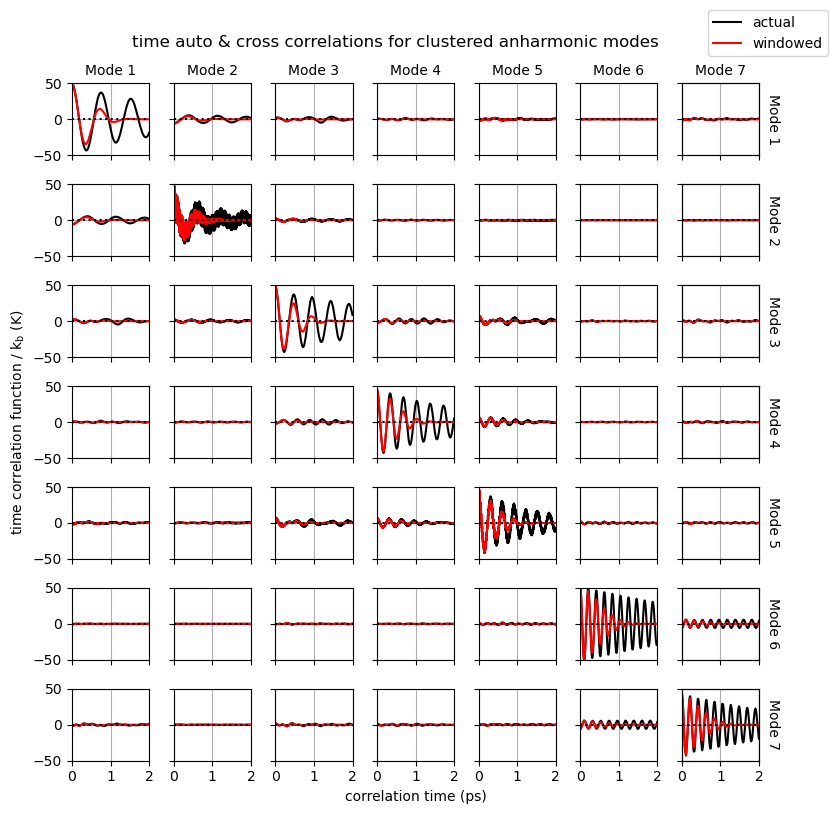

In [13]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(7, 7, figsize=(8,8), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(eigenvectorsCluster[i], np.dot(corrMatrix[k], eigenvectorsCluster[j]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # convert to mode temperature
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * nCorr
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-50, 50)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][3].set_xlabel("correlation time (ps)")
axs[3][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for clustered anharmonic modes")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-50, 51, 50))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+1}", fontsize=10)
for i, ax in enumerate(axs[:,6]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+1}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-gas-50K_anharmonic-modes-7x7-time-correlations.png', dpi=300)
plt.show()

Again, the cross correlations between distinct vibrational modes identified by our clustering algorithm are very small, confirming largely independent vibrations. 

This is pretty much what we would expect for harmonic normal modes, which we can expect to provide a reasonable description of the vibrations of this system given that it is a gas at low temperature. Thus, we will now compare our results from FRESEAN mode analysis with harmonic normal modes. 

Because we used the minimum energy structure as our reference for the rotational alignment in FRESEAN mode analysis, the vibrational modes detected by this fully anharmonic analysis can be compared directly to harmonic normal modes.

### Comparison to harmonic normal modes

<details>

Since we also performed harmonic mode analysis on our molecule (important: the energy minimized structure was also used as a reference structure for FRESEAN mode analysis), we can easily compute the 1D-VDoS of the harmonic modes using Eq. 12. Then we can compare the peaks frequencies in their VDoS with the predicted harmonic frequencies.

Further, we can compare how similar the harmonic normal modes are compared to the set of clustered anharmonic modes obtained from FRESEAN mode analysis.

Notably, for molecules simulated in the gas phase (with constraints preventing translation and rotation of the molecule), we ignore the first 6 harmonic normal modes (which describe translation and rotations).

</details>

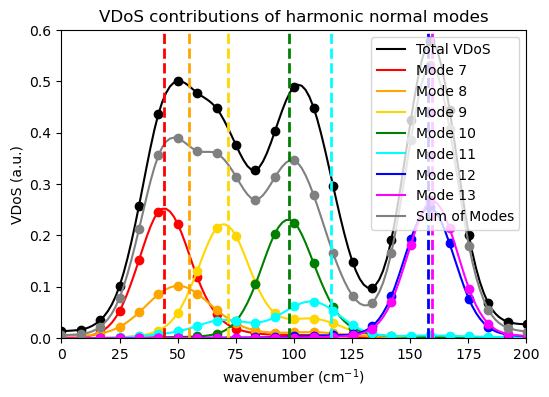

In [14]:
# generating data sets for plots
# importing harmonic normal modes for comparison
harmonic = mda.Universe("data/harmonic-normal-modes/eigenvec.xyz","data/harmonic-normal-modes/eigenvec.xyz")
harmonicModes = np.zeros((3 * nAtoms, 3 * nAtoms), dtype=np.float64)
for m in range(3 * nAtoms):
    harmonicModes[m] = harmonic.trajectory[m].positions.flatten()
# 1D-VDoS for all harmonic normal modes
# computed with Eq. 11 above
VDoSharmonicModes = np.zeros((3 * nAtoms, nCorr))
for m in range(3 * nAtoms):
    for i in range(nCorr):
        VDoSharmonicModes[m, i] = np.dot(harmonicModes[m], np.dot(corrMatrix[i], harmonicModes[m]))
# Import harmonic frequencies
harmonicFreqs = np.loadtxt('data/harmonic-normal-modes/eigenfreq.dat', comments='#')[:,1]

# plot 1D-VDoS of harmonic normal modes 7-12 (omit modes 1-6, which describe tranlations/rotations)
g.plotSpectra(freqs,
            [VDoStot] + [arr for arr in VDoSharmonicModes[6:13]] + [np.sum(VDoSharmonicModes[6:13], axis=0)],
            xlim=[0,200], 
            ylim=[0,0.6], 
            colors=['black', 'red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta', 'gray'],
            labels=['Total VDoS', 'Mode 7', 'Mode 8', 'Mode 9', 'Mode 10', 'Mode 11', 'Mode 12', 'Mode 13', 'Sum of Modes'],
            filename='figures/MD-gas-50K_harmonic-modes-VDoS.png',
            vlines = harmonicFreqs[6:13].tolist(),
            vlineColors = ['red', 'orange', 'gold', 'green', 'cyan', 'blue', 'magenta'],
            title = "VDoS contributions of harmonic normal modes")

The 1D-VDoS have some similarity to what we observed for the clustered anharmonic modes. However, there are a few notable differences, e.g., harmonic normal modess 9 & 11 have a multimodal spectrum. This indicates deviations from harmonic approximations. In comparison, our anharmonic vibrational modes were able to isolate distinct vibrations with unimodal spectra.

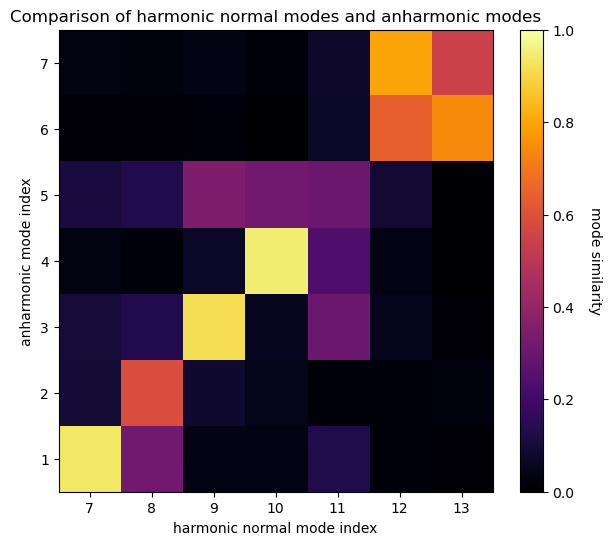

In [15]:
# compute comparison matrix between clustered vibrational modes and harmonic normal Modes
compareMatrix = np.zeros((nClusterModes,nClusterModes), dtype = np.float64)
for i in range(nClusterModes):
    for j in range(nClusterModes):
        compareMatrix[i,j] = np.abs(np.dot(eigenvectorsCluster[i],harmonicModes[j+6]))

# plot the comparison matrix
plt.figure(figsize=(7, 6))
im = plt.imshow(compareMatrix, aspect='auto', cmap='inferno', vmin=0, vmax=1)
n_ticks = compareMatrix.shape[0]
cbar = plt.colorbar(im)
cbar.set_label('mode similarity', rotation=270, labelpad=20)
plt.xlabel('harmonic normal mode index')
plt.ylabel('anharmonic mode index')
plt.gca().invert_yaxis()
plt.xticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1) + 6)
plt.yticks(ticks=np.arange(n_ticks), labels=np.arange(1, n_ticks + 1))
plt.title('Comparison of harmonic normal modes and anharmonic modes')
plt.savefig('figures/MD-gas-50K_harmonic-anharmonic-modes-comparison-matrix.png', dpi=300)
plt.show()

A comparison of the harmonic normal modes and the clustered anharmonic modes detected by FRESEAN shows some similarity. However, the two sets of modes are clearly not identical. Harmonic normal mode 11, which features a pronounced multimodal spectrum in the 1D-VDoS above, has the lowest similarity to the clustered anharmonic modes. Further, harmonic normal modes 12 and 13 correspond to distinct linear combinations of the cluster anharmonic modes 6 and 7.

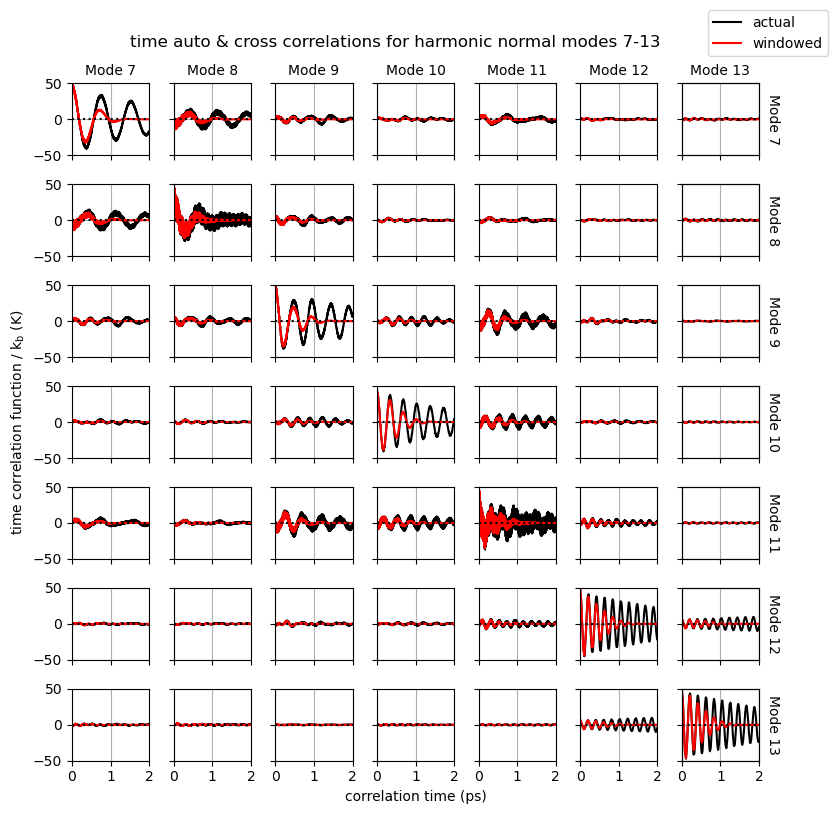

In [16]:
times = np.arange(nCorr) * dt
tmp1 = np.zeros(2 * nCorr - 1, dtype=np.float64)

fig, axs = plt.subplots(7, 7, figsize=(8,8), sharex=True, sharey=True)
for i, axrow in enumerate(axs):
    for j, ax in enumerate(axrow):
        for k in range(nCorr):
            tmp1[k] = np.dot(harmonicModes[i+6], np.dot(corrMatrix[k], harmonicModes[j+6]))
        tmp1[nCorr:] = tmp1[nCorr-1:0:-1]
        # convert to mode temperature
        vcf = np.real(ifft(tmp1))[:nCorr] * avgTemp * nCorr
        # if i != j:
        #     vcf *= 2
        #     ax.text(0.98, 0.9, 'x2', color='green', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # else:
        #     ax.text(0.98, 0.9, 'x1', color='black', fontsize=16, ha='right', va='center', transform=ax.transAxes)
        # remove window function entirely
        vcfActual = vcf / winTime[:nCorr] * winTime[0]
        ax.plot(times, vcfActual, color='black', label='actual')
        ax.plot(times, vcf, color='red', label='windowed')
        ax.set_xlim(0,2)
        ax.set_ylim(-50, 50)
        hlines = ax.axhline(0, color='black', linestyle=':')

axs[-1][3].set_xlabel("correlation time (ps)")
axs[3][0].set_ylabel(r"time correlation function / k$_{{\mathrm{b}}}$ (K)")
plt.suptitle(f"time auto & cross correlations for harmonic normal modes 7-13")
for ax in axs.flat:
    ax.label_outer()
    ax.grid(True)
for ax in axs.flat:
    ax.set_xticks(np.arange(0, 3, 1))
    ax.set_yticks(np.arange(-50, 51, 50))
    ax.set_aspect('auto')
    ax.grid(True)
for i, ax in enumerate(axs[0]):
    ax.set_title(f"Mode {i+7}", fontsize=10)
for i, ax in enumerate(axs[:,6]):
    ax2 = ax.twinx()
    ax2.set_ylabel(f"Mode {i+7}", rotation=270, va='center', ha='center', fontsize=10, labelpad=10)
    ax2.set_yticks([])
plt.tight_layout()
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.05, 1.02))
plt.savefig('figures/MD-gas-50K_harmonic-modes-7x7-time-correlations.png', dpi=300)
plt.show()

Notably, for a truly harmonic system, cross correlations of fluctuations between distinct harmonic normal modes should be zero (off-diagonal plots). Instead we find cross correlations between multiple pairs of harmonic modes. 

Interestingly, the cross correlations betwene the harmonic normal modes are larger than what we observed for the clustered anharmonic modes obtained from FRESEAN mode analysis above. This is a clear indication that harmonic normal modes are not the best way to describe the vibrations even for this rather simple system at low temperature.

## **Vibrational Mode Visualization**

In the following, we can visualize vibrational modes. Importantly, the eigenvectors of either $\mathbf{C}_{\tilde{\mathrm{v}}}(\omega)$ or the mass-weighted Hessian matrix require scaling prior to visualization. 

This is usually done automatically by most programs that visualize vibrational modes. The easiest way to show this is by computing the dot products between the eigenvectors of a given matrix. If the vectors are not orthonormal, they have been modified.

To convert eigenvector components into displacements suitable for visualization, we scale them with $1/\sqrt{m}$, where $m$ is the mass of the corresponding atom.

We begin by (re-)loading our reference structure, which we will use to visualize the atomic displacement vectors described by the eigenvectors of $\mathbf{C}_{\tilde{v}}(\omega)$ or the harmonic normal modes.

Once you are done, continue with <font style="font-family: courier; color: cyan">02-tutorial_MD-gas-300K.ipynb</font>

In [17]:
uVis = mda.Universe("data/MD-gas-50K/topol.tpr","data/harmonic-normal-modes/min.xyz")
selVis = uVis.select_atoms("all")

In [18]:
# anharmonic mode visualization (any eigenvectors at any frequency can be visualized)
# frequency index (any value between 1 and nCorr)
frequencyIndex = 7
# mode index (any value between 1 and 66 = 3 * nAtoms)
modeNumber = 1
print(f"Selected eigenvector {modeNumber} at frequency {freqs[frequencyIndex-1]:.1f} cm$^{-1}$")
disp = np.reshape(eigenvectors[frequencyIndex-1, modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected eigenvector 1 at frequency 50.1 cm$^-1$


Widget(value='<iframe src="http://localhost:54090/index.html?ui=P_0x1bab21a30_0&reconnect=auto" class="pyvista…

In [19]:
# clustered anharmonic mode visualization (select one of the cluster centers)
# mode index (any value between 1 and 7)
modeNumber = 1
print(f"Selected clustered anharmonic mode {modeNumber} with peak at frequency {freqs[peak_indices_cluster_modes[modeNumber-1]]:.1f} cm$^{-1}$")
disp = np.reshape(eigenvectorsCluster[modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected clustered anharmonic mode 1 with peak at frequency 41.7 cm$^-1$


Widget(value='<iframe src="http://localhost:54090/index.html?ui=P_0x1ba8cef30_1&reconnect=auto" class="pyvista…

In [20]:
# harmonic normal mode visualization
# mode number (any value between 1 and 66 = 3 * nAtoms)
# harmonic normal modes 1-6 describe translations/rotations (or linear combinations thereof)
modeNumber = 4
print(f"Selected harmonic mode {modeNumber} at frequency {harmonicFreqs[modeNumber-1]:.1f} cm$^{-1}$")
disp = np.reshape(harmonicModes[modeNumber-1].flatten() / sqm, (nAtoms, 3))
g.molecule(selVis, modeDisp=disp, modeScale=10)

Selected harmonic mode 4 at frequency 0.0 cm$^-1$


Widget(value='<iframe src="http://localhost:54090/index.html?ui=P_0x1baa95160_2&reconnect=auto" class="pyvista…